<a href="https://colab.research.google.com/github/Sheetal-R/Melanoma_detection_assignment/blob/main/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.</br>

**Project Pipeline**
- Data Reading/Data Understanding → Defining the path for train and test images
- Dataset Creation→ Create train & validation dataset from the train directory with a batch size of 32. Also, make sure you resize your images to 180*180.
- Dataset visualisation → Create a code to visualize one instance of all the nine classes present in the dataset
- Model Building & training :
  - Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescale images to normalize pixel values between (0,1).
  - Choose an appropriate optimiser and loss function for model training
  - Train the model for ~20 epochs
  - Write your findings after the model fit. You must check if there is any evidence of model overfit or underfit.
- Chose an appropriate data augmentation strategy to resolve underfitting/overfitting
- Model Building & training on the augmented data :
  - Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model rescale images to normalize pixel values between (0,1).
  - Choose an appropriate optimiser and loss function for model training
  - Train the model for ~20 epochs
  - Write your findings after the model fit, see if the earlier issue is resolved or not?
- Class distribution: Examine the current class distribution in the training dataset
  - Which class has the least number of samples?
  - Which classes dominate the data in terms of the proportionate number of samples?
- Handling class imbalances: Rectify class imbalances present in the training dataset with Augmentor library.
- Model Building & training on the rectified class imbalance data :
  - Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescale images to normalize pixel values between (0,1).
  - Choose an appropriate optimiser and loss function for model training
  - Train the model for ~30 epochs
  - Write your findings after the model fit, see if the issues are resolved or not?

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jul 11 08:17:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Importing Libraries

In [2]:
!pip install -q keras

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab import drive
from glob import  glob

### Mount Google Drive and use path to import the train and test data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

Create DF to View Data

In [6]:
# Create dataframes
train_df = pd.DataFrame(columns=['image_path', 'label'])
test_df = pd.DataFrame(columns=['image_path', 'label'])

In [7]:
# Add images paths and labels to dataframes

def appendDictToDF(df,dictToAppend):
  df = pd.concat([df, pd.DataFrame.from_records([dictToAppend])])
  return df


for label, directory in enumerate(os.listdir(data_dir_train)):
    for filename in os.listdir(os.path.join(data_dir_train, directory)):
        image_path = os.path.join(data_dir_train, directory, filename)
        #train_df = train_df.append({'image_path': image_path, 'label': label}, ignore_index=True)
        train_df = appendDictToDF(train_df,{'image_path': image_path, 'label': label})


for label, directory in enumerate(os.listdir(data_dir_test)):
    for filename in os.listdir(os.path.join(data_dir_test, directory)):
        image_path = os.path.join(data_dir_test, directory, filename)
        test_df = appendDictToDF(test_df,{'image_path': image_path, 'label': label})

In [8]:
print(train_df.shape)
print(test_df.shape)

(2239, 2)
(118, 2)


In [9]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [10]:
# Get list of directories in train_dir
labels = os.listdir(data_dir_train)

# Create label_map dictionary
label_map = {i: label for i, label in enumerate(labels)}
num_classes=len(label_map)
label_map

{0: 'actinic keratosis',
 1: 'nevus',
 2: 'seborrheic keratosis',
 3: 'dermatofibroma',
 4: 'pigmented benign keratosis',
 5: 'vascular lesion',
 6: 'squamous cell carcinoma',
 7: 'basal cell carcinoma',
 8: 'melanoma'}

In [11]:
# Count the number of images in each class
class_counts = train_df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              114       
1               nevus                          357       
2               seborrheic keratosis           77        
3               dermatofibroma                 95        
4               pigmented benign keratosis     462       
5               vascular lesion                139       
6               squamous cell carcinoma        181       
7               basal cell carcinoma           376       
8               melanoma                       438       
------------------------------------------------------------
Total                                         2239      


Found 2239 files belonging to 9 classes.

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [12]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [13]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [14]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [15]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

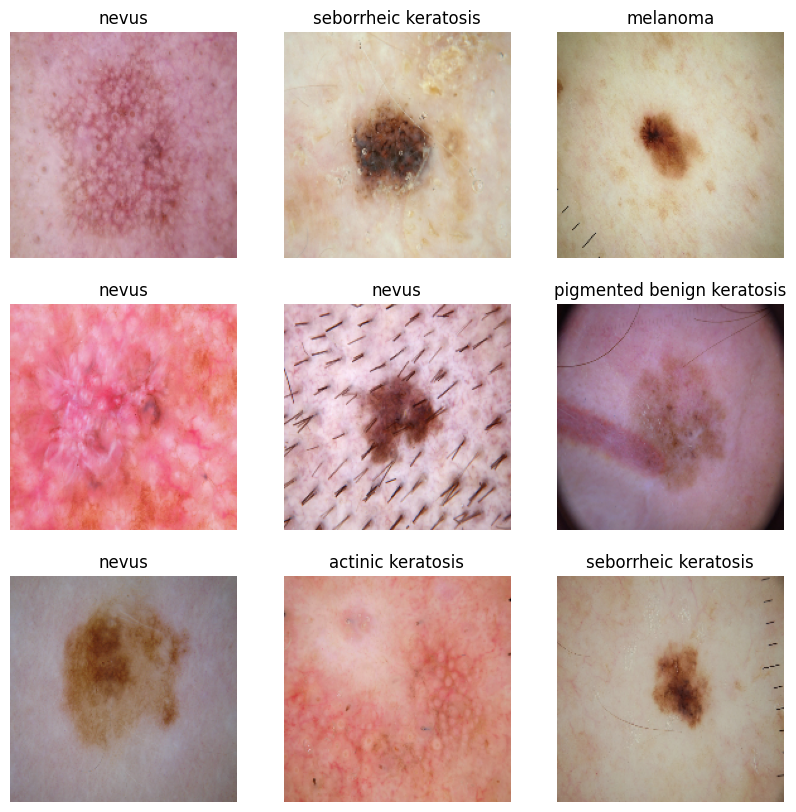

In [16]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [18]:
### Your code goes here
num_classes = 9 # as target class has 9 labels
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1.0/255),
  layers.Conv2D(32, (3, 3), padding="same", activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(32, (3, 3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(128, (3, 3), padding="same", activation='relu'),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(256, (3, 3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [19]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
# View the summary of all layers
model.build(input_shape=(None,180,180,3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 88, 88, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 44, 44, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 42, 42, 64)        1

### Train the model

In [21]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 209s 87ms/step - loss: 2.0523 - accuracy: 0.1897 - val_loss: 2.3884 - val_accuracy: 0.1304
Epoch 2/20
56/56 [==============================] - 1s 14ms/step - loss: 1.8664 - accuracy: 0.2712 - val_loss: 2.2614 - val_accuracy: 0.1739
Epoch 3/20
56/56 [==============================] - 1s 14ms/step - loss: 1.6784 - accuracy: 0.3689 - val_loss: 2.3137 - val_accuracy: 0.2609
Epoch 4/20
56/56 [==============================] - 1s 14ms/step - loss: 1.6835 - accuracy: 0.3650 - val_loss: 2.4171 - val_accuracy: 0.3043
Epoch 5/20
56/56 [==============================] - 1s 14ms/step - loss: 1.5533 - accuracy: 0.4241 - val_loss: 2.8663 - val_accuracy: 0.3043
Epoch 6/20
56/56 [==============================] - 1s 14ms/step - loss: 1.5635 - accuracy: 0.4369 - val_loss: 2.5487 - val_accuracy: 0.2609
Epoch 7/20
56/56 [==============================] - 1s 14ms/step - loss: 1.4524 - accuracy: 0.4877 - val_loss: 2.7776 - val_accuracy: 0.2609
Epoch 8/20


### Visualizing training results

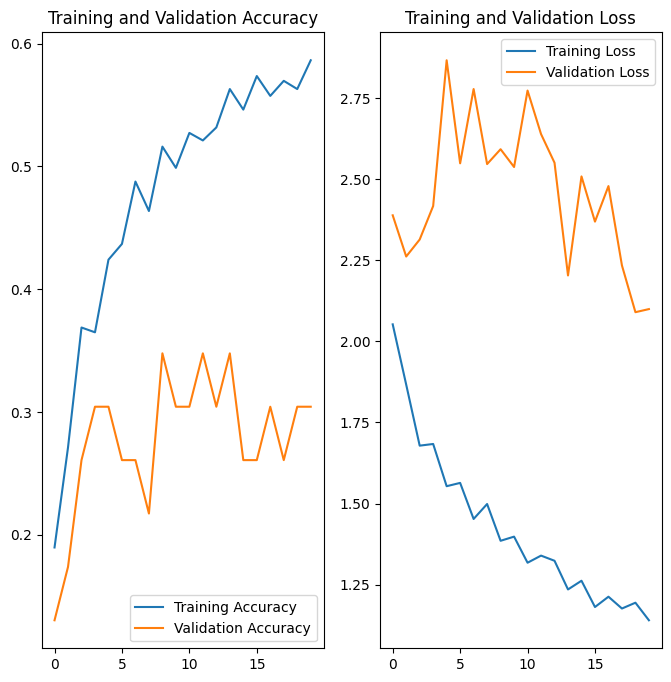

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [23]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",input_shape=(img_height, img_width, 3)),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.1),
])

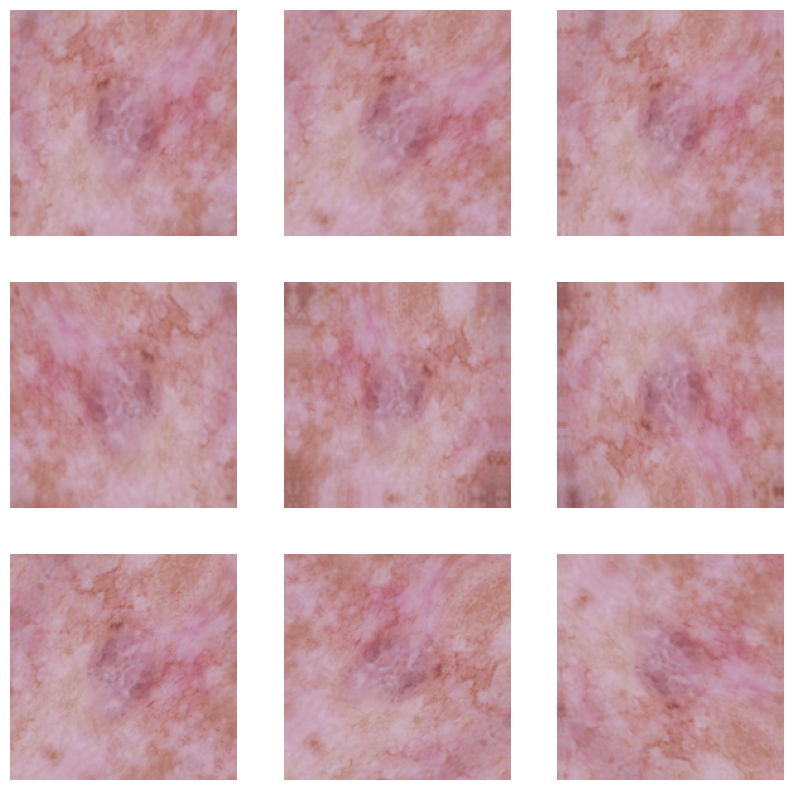

In [24]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(2):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [25]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1.0/255),
  layers.Conv2D(32, (3, 3), padding="same", activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(32, (3, 3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.25),
  layers.Conv2D(128, (3, 3), padding="same", activation='relu'),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(256, (3, 3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [26]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.build(input_shape=(None,180,180,3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 88, 88, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 44, 44, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 42, 42, 64)       

### Training the model

In [28]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds, epochs=epochs)

Epoch 1/20
56/56 [==============================] - 4s 21ms/step - loss: 2.0586 - accuracy: 0.1914 - val_loss: 2.3002 - val_accuracy: 0.1739
Epoch 2/20
56/56 [==============================] - 1s 18ms/step - loss: 2.0237 - accuracy: 0.1953 - val_loss: 2.3258 - val_accuracy: 0.0870
Epoch 3/20
56/56 [==============================] - 1s 18ms/step - loss: 1.9662 - accuracy: 0.2467 - val_loss: 2.4922 - val_accuracy: 0.0870
Epoch 4/20
56/56 [==============================] - 1s 18ms/step - loss: 1.8882 - accuracy: 0.2734 - val_loss: 2.2851 - val_accuracy: 0.2609
Epoch 5/20
56/56 [==============================] - 1s 18ms/step - loss: 1.7669 - accuracy: 0.3304 - val_loss: 2.6249 - val_accuracy: 0.2609
Epoch 6/20
56/56 [==============================] - 1s 19ms/step - loss: 1.6678 - accuracy: 0.3945 - val_loss: 2.2013 - val_accuracy: 0.3043
Epoch 7/20
56/56 [==============================] - 1s 19ms/step - loss: 1.5920 - accuracy: 0.4202 - val_loss: 2.5432 - val_accuracy: 0.2609
Epoch 8/20
56

### Visualizing the results

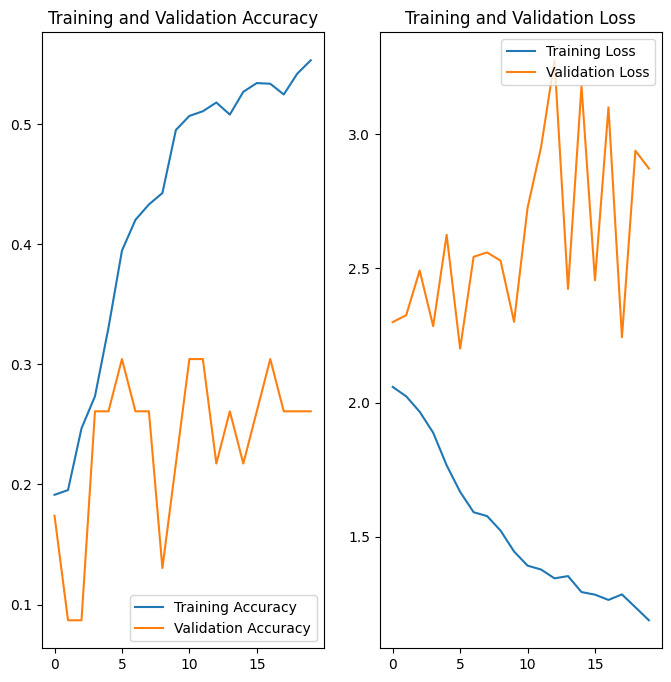

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [30]:
## Your code goes here.
labels = {0 : "actinic", 1: "basel", 2: "dermatofibroma", 3: "melanoma", 4: "nevus",
          5: "pigmented", 6: "seborrheic", 7: "squamous", 8: "vascular"}

def get_classes_distribution(data):
    # Get the count for each label
    label_counts = data['label'].value_counts()

    # Get total number of samples
    total_samples = len(data)


    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = labels[label_counts.index[i]]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {} or {}%".format(label, count, percent))

In [31]:
get_classes_distribution(train_df)

nevus               :   462 or 20.634211701652525%
vascular            :   438 or 19.56230460026798%
squamous            :   376 or 16.793211255024566%
basel               :   357 or 15.944618133095132%
seborrheic          :   181 or 8.083966056275123%
pigmented           :   139 or 6.208128628852166%
actinic             :   114 or 5.091558731576597%
melanoma            :   95 or 4.242965609647164%
dermatofibroma      :   77 or 3.439035283608754%


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [32]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [33]:
path_to_training_dataset="/content/drive/MyDrive/Colab Notebooks/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1DF6DCFEE0>: 100%|██████████| 500/500 [00:11<00:00, 44.21 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1EB0401ED0>: 100%|██████████| 500/500 [00:14<00:00, 35.65 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1EB031BCD0>: 100%|██████████| 500/500 [00:11<00:00, 43.12 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1EB038A710>: 100%|██████████| 500/500 [00:53<00:00,  9.34 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F1EB0131ED0>: 100%|██████████| 500/500 [00:49<00:00, 10.20 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1EB031A3B0>: 100%|██████████| 500/500 [00:11<00:00, 44.76 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1DF6D7B880>: 100%|██████████| 500/500 [00:24<00:00, 20.26 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1EB02E60B0>: 100%|██████████| 500/500 [00:11<00:00, 43.99 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1EB03B3BB0>: 100%|██████████| 500/500 [00:11<00:00, 43.85 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [34]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [35]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/drive/MyDrive/Colab Notebooks/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031040.jpg_fcf82bae-d73f-4f1d-b608-e8770d8ff3ec.jpg',
 '/content/drive/MyDrive/Colab Notebooks/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026040.jpg_8814ba26-cdc4-4b88-a122-86c13c9519d2.jpg',
 '/content/drive/MyDrive/Colab Notebooks/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029309.jpg_2541c6da-bbe5-4660-bf8b-a60fef940662.jpg',
 '/content/drive/MyDrive/Colab Notebooks/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026149.jpg_4f3e446b-d57b-423b-aefd-9c17f1899d82.jpg',
 '/content/drive/MyDrive/Colab Notebooks/CNN-Assignment/

In [36]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [37]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [38]:
path_list = [x for x in glob(os.path.join(data_dir_train,'*','*.jpg'))]

In [39]:
lesion_list = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train,'*','*.jpg'))]

In [40]:
dataframe_dict = dict(zip(path_list, lesion_list))

In [41]:
original_df = pd.DataFrame(list(dataframe_dict.items()),columns=['Path','Label'])

In [42]:
original_df['Label'].value_counts()

Train    2239
Name: Label, dtype: int64

In [43]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-43-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [44]:
new_df['Label'].value_counts()

Train                         2239
actinic keratosis              500
nevus                          500
seborrheic keratosis           500
dermatofibroma                 500
pigmented benign keratosis     500
vascular lesion                500
squamous cell carcinoma        500
basal cell carcinoma           500
melanoma                       500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [45]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [46]:
data_dir_train="/content/drive/MyDrive/Colab Notebooks/CNN-Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [47]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [48]:
## your code goes here
num_classes = 9
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1.0/255),
  layers.Conv2D(32, (3, 3), padding="same", activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(32, (3, 3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(128, (3, 3), padding="same", activation='relu'),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(256, (3, 3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes)
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [49]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [50]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 41s 217ms/step - loss: 2.0601 - accuracy: 0.1912 - val_loss: 1.8951 - val_accuracy: 0.2910
Epoch 2/30
169/169 [==============================] - 21s 122ms/step - loss: 1.7121 - accuracy: 0.3372 - val_loss: 1.5261 - val_accuracy: 0.4143
Epoch 3/30
169/169 [==============================] - 23s 134ms/step - loss: 1.4807 - accuracy: 0.4175 - val_loss: 1.4771 - val_accuracy: 0.4358
Epoch 4/30
169/169 [==============================] - 21s 119ms/step - loss: 1.4223 - accuracy: 0.4503 - val_loss: 1.3620 - val_accuracy: 0.5033
Epoch 5/30
169/169 [==============================] - 21s 122ms/step - loss: 1.3239 - accuracy: 0.4776 - val_loss: 1.3226 - val_accuracy: 0.4818
Epoch 6/30
169/169 [==============================] - 21s 120ms/step - loss: 1.2468 - accuracy: 0.5106 - val_loss: 1.3497 - val_accuracy: 0.4900
Epoch 7/30
169/169 [==============================] - 22s 124ms/step - loss: 1.1674 - accuracy: 0.5488 - val_loss: 1.1612 - val_ac

#### **Todo:**  Visualize the model results

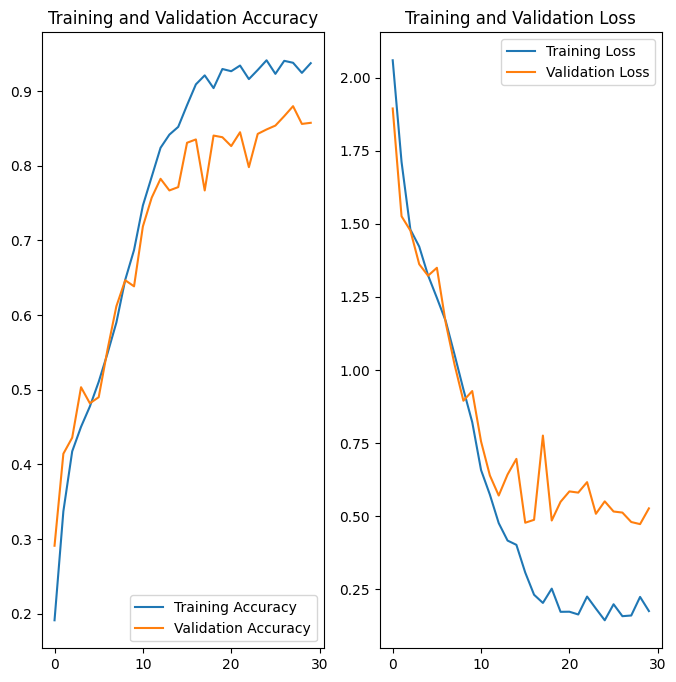

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
